# Recurrent Neural Network (Long Short-Term Memory)

## Import libraries

In [1]:
import os
import tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

import wget
import numpy as np
import pandas as pd
import shutil
import zipfile
import matplotlib.pyplot as plt
import warnings
from distutils.dir_util import copy_tree
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

Using TensorFlow backend.


## Get dataset

In [2]:
if os.path.exists('data'):
    print("Path already exists")
else:
    print("Creating the data directory")
    os.mkdir('data')
    print("Directory created")

Creating the data directory
Directory created


In [3]:
data_url = 'https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/P16-Recurrent-Neural-Networks.zip'
file_name = data_url.split("/")[-1]
if not os.path.exists('data/training_set'):
    print('Need to download dataset')
    wget.download(data_url, out = 'data')
    print('Data downloaded')
    with zipfile.ZipFile('data/' + file_name, 'r') as file:
        print("Extracting dataset")
        file.extractall()
        copy_tree('Recurrent_Neural_Networks/', 'data/')
        print("Dataset extracted and created")
    try:
        shutil.rmtree('Recurrent_Neural_Networks')
        os.remove('data/' + file_name)
        print("Extra files removed")
    except:
        print("Could not delete extra files")
else:
    print('Dataset available')

Need to download dataset
Data downloaded
Extracting dataset
Dataset extracted and created
Extra files removed


In [4]:
dataset_train = pd.read_csv('data/Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values

## Data processing

### Applying MinMaxScaler

In [5]:
from sklearn.preprocessing import MinMaxScaler

minMaxScaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = minMaxScaler.fit_transform(training_set)

### Creating the train data

Using 60 time steps (60 data points - 3 months as there are no weekends) to lead to one output.

In [6]:
X_train = []
y_train = []
for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train = np.array(X_train)
y_train = np.array(y_train)

### Applying reshape

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Model

In [8]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (60, 1)))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(rate = 0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1198/1198 [==============================] - 7s 6ms/step - loss: 0.0504
Epoch 2/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0056
Epoch 3/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0056
Epoch 4/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0046
Epoch 5/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0051
Epoch 6/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0052
Epoch 7/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0045
Epoch 8/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0047
Epoch 9/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0045
Epoch 10/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0048
Epoch 11/100
1198/1198 [==============================] - 5s 4ms/step - loss: 0.0043
Epoch 12/100
1198/1198 [==

1198/1198 [==============================] - 6s 5ms/step - loss: 0.0015
Epoch 94/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0016
Epoch 95/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0014
Epoch 96/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0015
Epoch 97/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0017
Epoch 98/100
1198/1198 [==============================] - 5s 5ms/step - loss: 0.0016
Epoch 99/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0015
Epoch 100/100
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0014


## Getting results

### Reading test data

In [10]:
dataset_test = pd.read_csv('data/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Predicting stock price

In [11]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = minMaxScaler.transform(inputs)

In [12]:
X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = minMaxScaler.inverse_transform(predicted_stock_price)

## Visualizing the results

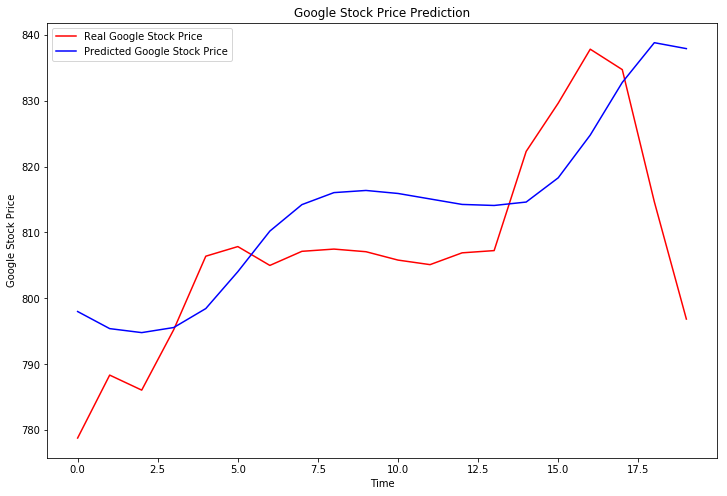

In [13]:
plt.figure(figsize = (12, 8))
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()